# Regresión
***
Red no Bayesiana, red VI, red MC Dropout
Ejemplo obtenido de: https://github.com/tensorchiefs/dl_book/blob/master/chapter_08/nb_ch08_03.ipynb

## Instalación de [Tensorflow Probability](https://www.tensorflow.org/probability)


In [1]:
!pip install tensorflow_probability

## Bibliotecas de Python

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
import urllib.request
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFP Version 0.22.0
TF  Version 2.14.0


# Generación de datos
***
* Se usan 2048 puntos


2168

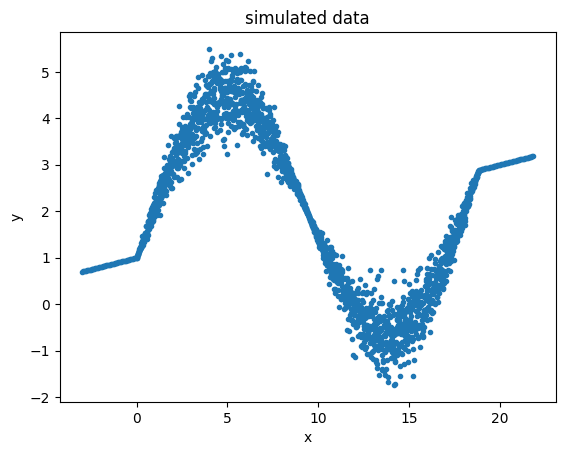

In [4]:
def create_sine_data(n = 2048):
    np.random.seed(32)
    x = np.linspace(0,1*2*np.pi,n)
    y1 = 3*np.sin(x)
    y1 = np.concatenate((np.zeros(60), y1+np.random.normal(0,0.15*np.abs(y1),n),np.zeros(60)))
    x=np.concatenate((np.linspace(-3,0,60),np.linspace(0,3*2*np.pi,n),np.linspace(3*2*np.pi,3*2*np.pi+3,60)))
    y2 = 0.1*x+1
    y=y1+y2
    return x,y

## use custom function to simulate some data
x,y = create_sine_data(2048) # Note that the model has been trained with 2048 data points #256
plt.scatter(x=x,y=y,marker='.',alpha=1)
plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")
n=len(x)
n

Rango de x:

In [6]:
x.min(), x.max()

(-3.0, 21.84955592153876)

# Red no Bayesiana
***
* Los pesos de la red son puntos (no distribuciones)

In [7]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def NLL(y, distr):
  return -distr.log_prob(y)

def normal_sp(params):
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

inputs = Input(shape=(1,))
hidden = Dense(20,activation="relu")(inputs)
hidden = Dense(50,activation="relu")(hidden)
hidden = Dense(20,activation="relu")(hidden)
params = Dense(2)(hidden)
dist = tfp.layers.DistributionLambda(normal_sp)(params)

model_nobay = Model(inputs=inputs, outputs=dist)
model_nobay.compile(Adam(), loss=NLL)

In [8]:
model_nobay.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 20)                40        
                                                                 
 dense_1 (Dense)             (None, 50)                1050      
                                                                 
 dense_2 (Dense)             (None, 20)                1020      
                                                                 
 dense_3 (Dense)             (None, 2)                 42        
                                                                 
 distribution_lambda (Distr  ((None, 1),               0         
 ibutionLambda)               (None, 1))                         
                                                             

In [9]:
history = model_nobay.fit(x, y, epochs=5000, verbose=0,batch_size=32)


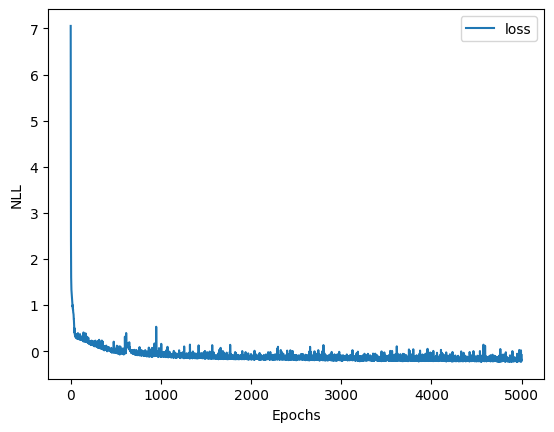

In [10]:
plt.plot(history.history['loss'])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

## Descomentar si demora mucho el entrenamiento

In [11]:
## download and load weights of the model
#urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_aleatoric_weights.hdf5", "model_nobay.hdf5")
#model_nobay.load_weights("model_nobay.hdf5")

In [12]:
#model_nobay = Model(inputs=inputs, outputs=dist)

## Datos nuevos
***
x_pred

In [14]:
x_pred = np.arange(-10,30,0.3)
for rep in range(2): #Predictions for two runs
    print("Run T = ", rep)
    print(model_nobay.predict(x_pred).T)


Run T =  0
5/5 [==============================] - 0s 3ms/step
[[ 0.65529615  0.65668094  0.6559934   0.6585508   0.6605015   0.66062564
   0.66103375  0.6648717   0.6671351   0.66899884  0.6691833   0.6722266
   0.673656    0.6743498   0.676211    0.6756926   0.6826054   0.6816819
   0.68555063  0.6821878   0.68757266  0.69458824  0.70399314  0.69679314
   0.6841703   0.77179116  0.7824048   0.791762    0.8194648   0.8720948
   0.9106823   0.9342179   0.95984644  0.9818795   1.2457993   1.5024673
   1.8849924   2.075775    2.5630074   2.7349021   2.7101882   3.5339916
   3.012589    4.4284344   4.430536    3.9413393   4.346379    4.4651165
   4.1345553   4.9234495   4.5184727   4.6222925   4.4007344   4.5256677
   4.7487736   4.441689    3.7452972   3.4072266   3.7768016   2.970137
   2.882878    2.8734908   2.6638424   2.2745152   2.1612322   1.7923031
   1.4923824   1.444753    1.265909    0.7668445   0.29208565  0.45378423
   0.33172774  0.23512879 -0.19219276 -0.20386934 -0.5687033

## 200 runs

In [15]:
runs = 200
nobay_cpd =np.zeros((runs,len(x_pred)))
for i in tqdm(range(0,runs)):
    nobay_cpd[i,:]=np.reshape(model_nobay.predict(x_pred),len(x_pred))

<ipython-input-15-cfce1cf06788>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(0,runs)):


  0%|          | 0/200 [00:00<?, ?it/s]

5/5 [==============================] - 0s 4ms/step


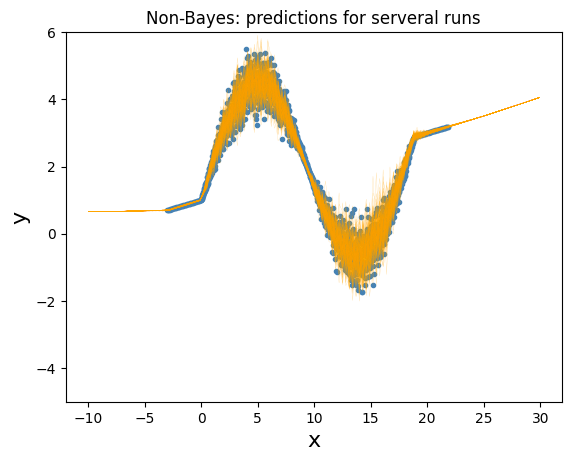

In [16]:
def make_plot_runs(ax, preds, alpha_data=1,ylim=[-7,8]):
    ax.scatter(x,y,color="steelblue", alpha=alpha_data,marker='.') #observerd
    for i in range(0,preds.shape[0]):
      ax.plot(x_pred, preds[i],color="orange",linewidth=.2, alpha=0.4)
    ax.set_ylim(ylim)

ax = plt.subplot()
make_plot_runs(ax, nobay_cpd)
plt.ylim([-5,6])
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title('Non-Bayes: predictions for serveral runs')
plt.show()

In [17]:
#np.quantile(nobay_cpd, 0.025, axis=0)

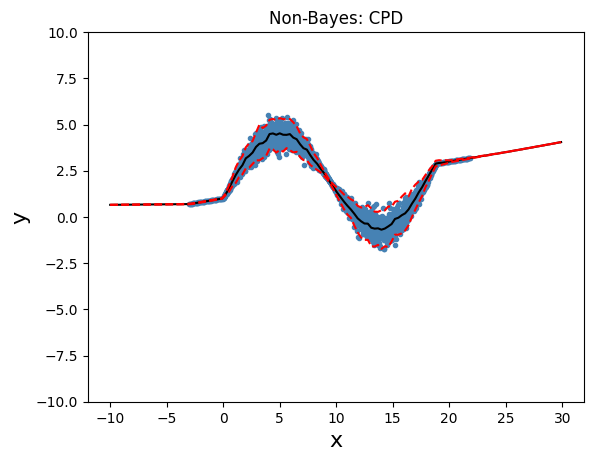

In [22]:
def make_plot_runs_avg(ax, preds, alpha_data=1,ylim=[-7,8]):
    ax.scatter(x,y,color="steelblue", alpha=alpha_data,marker='.') #observerd
    ax.set_ylim(ylim)
    ax.plot(x_pred,np.mean(preds,axis=0),color="black",linewidth=1.5)
    ax.plot(x_pred,np.quantile(preds, 0.025, axis=0),color="red",linewidth=1.5,linestyle="--")
    #print(preds)
    #print(np.quantile(preds, 0.025, axis=0))
    ax.plot(x_pred,np.quantile(preds, 0.975, axis=0),color="red",linewidth=1.5,linestyle="--")

ax = plt.subplot()
make_plot_runs_avg(ax, nobay_cpd)
plt.ylim([-10,10])
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title('Non-Bayes: CPD')
plt.show()

#  Regresión Bayesiana usando VI
***
La capa [DenseFlipout](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseFlipout) implementa la inferencia variacional bayesiana análoga a una capa densa suponiendo que los pesos y/o el sesgo se extraen de distribuciones.

In [23]:
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)


inputs = Input(shape=(1,))


hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(inputs)
hidden = tfp.layers.DenseFlipout(50,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
params = tfp.layers.DenseFlipout(2,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(hidden)
dist = tfp.layers.DistributionLambda(normal_sp)(params)


model_vi = Model(inputs=inputs, outputs=dist)
model_vi.compile(Adam(learning_rate=0.0002), loss=NLL)

model_params = Model(inputs=inputs, outputs=params)

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [24]:
model_vi.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_flipout (DenseFlipou  (None, 20)                80        
 t)                                                              
                                                                 
 dense_flipout_1 (DenseFlip  (None, 50)                2100      
 out)                                                            
                                                                 
 dense_flipout_2 (DenseFlip  (None, 20)                2040      
 out)                                                            
                                                                 
 dense_flipout_3 (DenseFlip  (None, 2)                 84        
 out)                                                      

time taken :  685.682


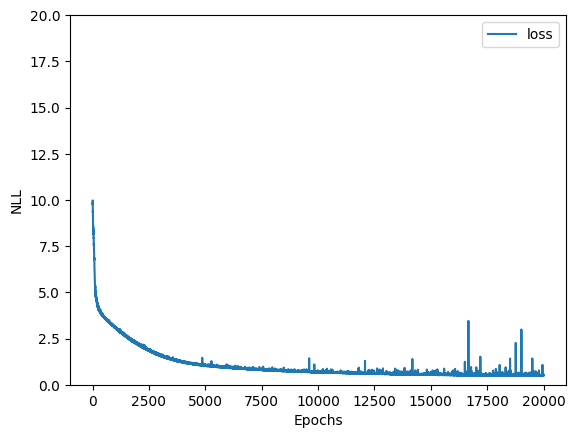

In [25]:
from time import time
start = time()
# Note that the model has been trained with 2048 data points
history = model_vi.fit(x, y, epochs=20000, verbose=0,batch_size=512)
print('time taken : ',np.round(time() - start,3)) #468 sec
# model_vi.save_weights('model_vi.hdf5')
plt.plot(history.history['loss'])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.ylim([0,20])
# model_vi.save_weights('model_vi.hdf5')
plt.show()

## Descomentar si demora mucho el entrenamiento

In [ ]:
#urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_vi.hdf5", "model_vi.hdf5")
#model_vi.load_weights("model_vi.hdf5")

In [26]:
for rep in range(2):
    print(model_vi.predict(x_pred)[0:3].T) #Samples from the posteriori predictive distribution, different for each run

5/5 [==============================] - 1s 4ms/step
[[1.8549775 1.2025468 2.7420459]]
5/5 [==============================] - 0s 3ms/step
[[0.30818617 1.7681199  0.45090482]]


In [27]:
for rep in range(2):
    print(model_params.predict(x_pred)[0:3].T)

5/5 [==============================] - 1s 3ms/step
[[   0.20035583    1.4920157    -0.5448532 ]
 [-121.07399    -104.409065    -13.8166275 ]]
5/5 [==============================] - 0s 3ms/step
[[  0.9653568   2.227933    0.7236005]
 [-63.975754  -94.421326  -79.624886 ]]


In [28]:
vi_cpd =np.zeros((runs,len(x_pred)))
for i in tqdm(range(0,runs)):
    vi_cpd[i,:]=np.reshape(model_vi.predict(x_pred),len(x_pred))

<ipython-input-28-2f099d2229c1>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(0,runs)):


  0%|          | 0/200 [00:00<?, ?it/s]

5/5 [==============================] - 0s 3ms/step


# MC Dropout

In [29]:
def normal_exp(params):
  return tfd.Normal(loc=params[:,0:1], scale=tf.math.exp(params[:,1:2]))# both parameters are learnable

In [30]:
from tensorflow.keras.layers import Dropout

inputs = Input(shape=(1,))
hidden = Dense(200,activation="relu")(inputs)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(200,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
params_mc = Dense(2)(hidden)
dist_mc = tfp.layers.DistributionLambda(normal_exp, name='normal_exp')(params_mc)

model_mc = Model(inputs=inputs, outputs=dist_mc)
model_mc.compile(Adam(learning_rate=0.0002), loss=NLL)

In [31]:
model_mc.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_4 (Dense)             (None, 200)               400       
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 500)               100500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_6 (Dense)             (None, 500)               250500    
                                                                 
 dropout_2 (Dropout)         (None, 500)               0   

time taken :  260.312


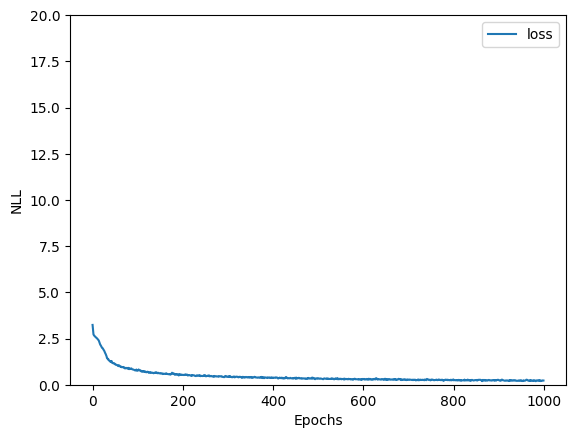

In [32]:
start = time()
# Note that the model has been trained with 2048 data points
history = model_mc.fit(x, y, epochs=1000, verbose=0,batch_size=512)
print('time taken : ',np.round(time() - start,3)) #468 sec
# model_vi.save_weights('model_mc.hdf5')
plt.plot(history.history['loss'])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.ylim([0,20])
plt.show()

In [33]:
mc_cpd =np.zeros((runs,len(x_pred)))
for i in tqdm(range(0,runs)):
    mc_cpd[i,:]=np.reshape(model_mc.predict(x_pred),len(x_pred))

<ipython-input-33-3e7ce5f77ad5>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(0,runs)):


  0%|          | 0/200 [00:00<?, ?it/s]

5/5 [==============================] - 0s 6ms/step


(array([ 1.,  0.,  3.,  9., 35., 53., 65., 27.,  5.,  2.]),
 array([1.05633843, 1.35852391, 1.66070938, 1.96289486, 2.26508033,
        2.56726581, 2.86945128, 3.17163676, 3.47382224, 3.77600771,
        4.07819319]),
 <BarContainer object of 10 artists>)

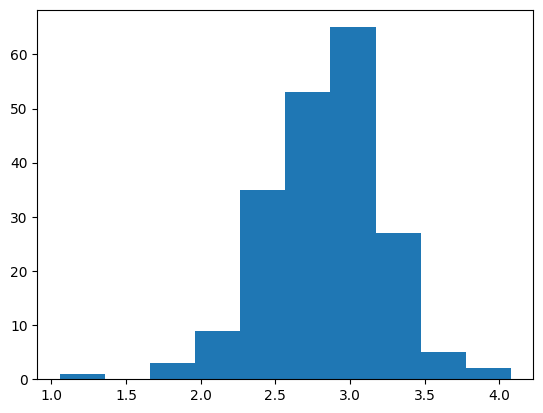

In [34]:
plt.hist(mc_cpd[:,100])

# Resumen

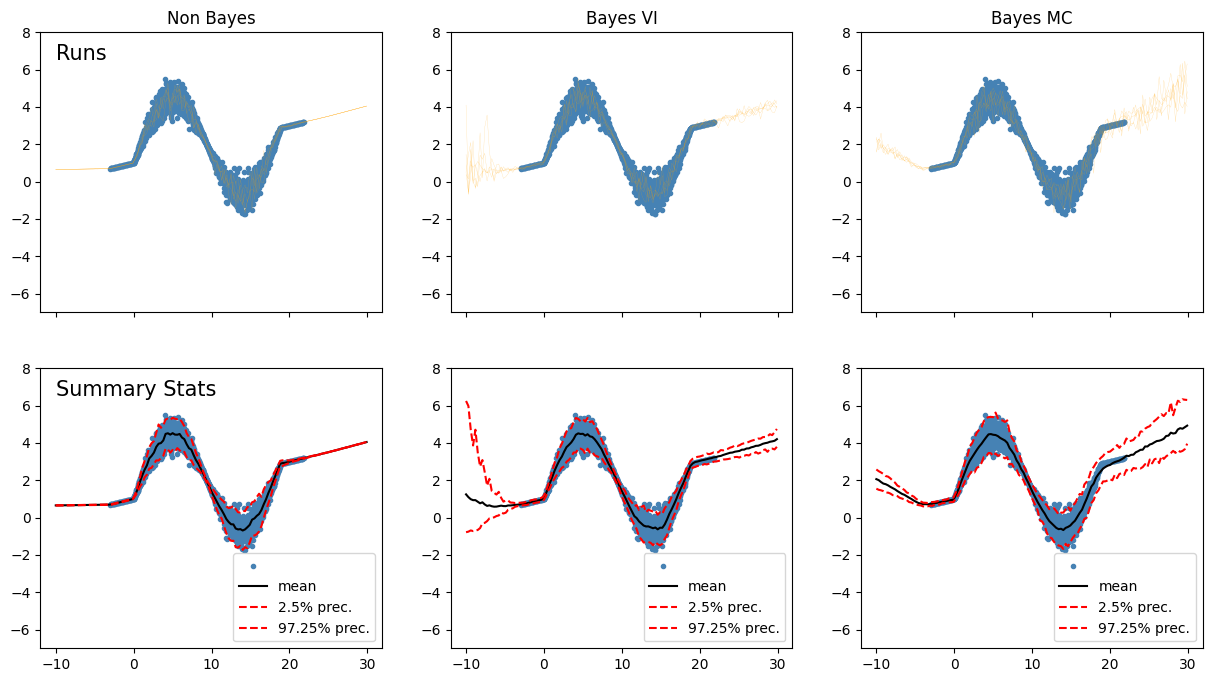

In [35]:
#plt.figure(figsize=(5,25))
f,ax = plt.subplots(2,3,sharex=True, sharey=False,figsize=(15,8))

lines = 5

make_plot_runs(ax[0,0], nobay_cpd[0:lines])
#make_no_bayes_plot(ax[0,1], model_nobay_mean, model_nobay_sd, add_std=False,ylim=[-7,8])
ax[0,0].set_title('Non Bayes')
make_plot_runs_avg(ax[1,0],nobay_cpd)
ax[1,0].legend(('','mean','2.5% prec.','97.25% prec.'), loc='lower right')

ax[0,1].set_title('Bayes VI')
make_plot_runs(ax[0,1], vi_cpd[0:lines], ylim=[-7,8])
make_plot_runs_avg(ax[1,1], vi_cpd, ylim=[-7,8])
ax[1,1].legend(('','mean','2.5% prec.','97.25% prec.'), loc='lower right')

ax[0,2].set_title('Bayes MC')
make_plot_runs(ax[0,2], mc_cpd[0:lines], ylim=[-7,8])
make_plot_runs_avg(ax[1,2], mc_cpd, ylim=[-7,8])
ax[1,2].legend(('','mean','2.5% prec.','97.25% prec.'), loc='lower right')

#ax[0,0].axis('off')
ax[0,0].text(-10,6.5, "Runs",fontsize=15,horizontalalignment='left')

#ax[1,0].axis('off')
ax[1,0].text(-10,6.5, "Summary Stats",fontsize=15,horizontalalignment='left')


plt.show()